In [922]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

import itertools
import numpy as np
import pandas as pd
from tqdm.notebook import tqdm

import matplotlib.pyplot as plt
%matplotlib inline

import keras
import tensorflow as tf
import keras.backend as K
from keras.layers import Dense, Dropout, Input, Concatenate
from keras.models import Model, Sequential
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
from keras.layers.advanced_activations import LeakyReLU
from tensorflow_model_remediation.min_diff.losses import MMDLoss
from tensorflow_model_remediation.min_diff.keras.models.min_diff_model import MinDiffModel

In [4]:
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        tf.config.experimental.set_virtual_device_configuration(
            gpus[0],[tf.config.experimental.VirtualDeviceConfiguration(memory_limit=5120)])
    except RuntimeError as e:
        print(e)

In [401]:
def get_m_values(df):
    e_sum_sq = np.power(df['E1'] + df['E2'] + df['E3'] + df['E4'], 2)
    x_sum_sq = np.power(df['p1x'] + df['p2x'] + df['p3x'] + df['p4x'], 2)
    y_sum_sq = np.power(df['p1y'] + df['p2y'] + df['p3y'] + df['p4y'], 2)
    z_sum_sq = np.power(df['p1z'] + df['p2z'] + df['p3z'] + df['p4z'], 2)
    m_values = np.sqrt(e_sum_sq - x_sum_sq - y_sum_sq - z_sum_sq)
    return m_values

# Data prep

In [6]:
data_raw = pd.read_csv('../data/pp_4l_all.csv')
data_raw

,pdg1,E1,p1x,p1y,p1z,pdg2,E2,p2x,p2y,p2z,pdg3,E3,p3x,p3y,p3z,pdg4,E4,p4x,p4y,p4z
0,11,20.274241,13.753708,1.397849,14.829915,-11,13.459523,-13.458053,-0.178631,0.087476,13,10.726935,1.457106,-9.715445,-4.306151,-13,19.941356,-1.752761,8.496227,17.955180
1,13,152.820099,63.584427,18.996694,-137.659427,-13,164.917905,4.471840,31.646155,-161.791309,13,137.529487,-39.586901,-44.338982,-124.021291,-13,39.559938,-28.469366,-6.303867,-26.734509
2,11,51.267102,27.995380,26.039697,34.154190,-11,43.013595,-7.827488,-17.337374,-38.578689,13,123.210062,0.378806,-41.833551,115.890116,-13,46.883635,-20.546697,33.131228,26.042638
3,13,64.805282,-3.653628,46.355274,45.139262,-13,38.158727,-29.094263,-15.298609,-19.379208,13,57.805237,34.629435,10.578369,45.059234,-13,42.993259,-1.881544,-41.635034,10.554281
4,13,25.501529,17.607195,-7.617831,-16.800957,-13,22.270427,3.366801,16.786119,-14.242599,13,36.269401,-21.935459,13.187325,-25.698023,-13,47.012227,0.961463,-22.355613,-41.345380
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19995,13,104.780662,42.444194,-70.801849,64.533437,-13,40.669899,15.498023,29.488293,23.329839,13,70.717828,-10.422217,-15.453176,68.217130,-13,76.806457,-47.520000,56.766732,20.459923
19996,11,41.767784,24.968553,-8.233132,32.455118,-11,70.293006,-59.382010,26.894480,26.297730,13,13.512633,5.146302,-11.949588,-3.647330,-13,35.067493,29.267155,-6.711760,18.113636
19997,13,165.372773,42.569775,-26.508450,-157.585720,-13,129.240829,-42.380560,7.956206,-121.835002,13,110.152618,-40.177549,23.109741,99.926436,-13,49.993973,39.988334,-4.557497,29.657184
19998,11,30.643742,9.530088,-16.555072,-23.961342,-11,32.651847,8.507474,-6.286373,-30.890897,13,123.211921,-19.275757,37.041656,-115.920349,-13,36.569459,1.238196,-14.200210,-33.676921


In [7]:
particles = (
    ['pdg1', 'E1', 'p1x', 'p1y', 'p1z'],
    ['pdg2', 'E2', 'p2x', 'p2y', 'p2z'],
    ['pdg3', 'E3', 'p3x', 'p3y', 'p3z'], 
    ['pdg4', 'E4', 'p4x', 'p4y', 'p4z']
)
particle_types = {
    11: 'e-', -11: 'e+',
    13: 'm-', -13: 'm+'
}

In [8]:
data_stack = None
for i in range(4):
    d = data_raw.values[:, 5*i:5*i+5]
    data_stack = d if data_stack is None else np.append(data_stack, d, axis = 0)
data_stack.shape

(80000, 5)

In [9]:
scaler = MinMaxScaler().fit(data_stack[:, 1:])
data_stack[:, 1:] = scaler.transform(data_stack[:, 1:])

In [10]:
i = data_stack.shape[0] // 4
data = data_stack[0:i]
data = np.append(data, data_stack[i:i*2], axis=1)
data = np.append(data, data_stack[i*2:i*3], axis=1)
data = np.append(data, data_stack[i*3:i*4], axis=1)
data.shape

(20000, 20)

In [11]:
pcols = [(np.array([0,1,2,3,4]) + 5 * i).tolist() for i in range(4)]
pcols

[[0, 1, 2, 3, 4], [5, 6, 7, 8, 9], [10, 11, 12, 13, 14], [15, 16, 17, 18, 19]]

In [12]:
data0 = None
for p in itertools.permutations(range(len(pcols)), len(pcols)):
    c = np.array([ [] + pcols[i] for i in p ]).flatten().tolist()
    d = data[:,c]
    data0 = d if data is None else np.append(data, d, axis = 0)
data0.shape

(40000, 20)

In [13]:
particle_type_cols = [0,5,10,15]
particle_prop_cols = [i for i in range(data0.shape[1]) if i not in particle_type_cols]
event_types, event_codes = np.unique(data0[:,particle_type_cols], axis=0, return_inverse=True)
event_types

array([[-13.,  13., -13.,  13.],
       [-13.,  13., -11.,  11.],
       [-11.,  11., -11.,  11.],
       [ 11., -11.,  11., -11.],
       [ 11., -11.,  13., -13.],
       [ 13., -13.,  13., -13.]])

In [14]:
enc = OneHotEncoder(handle_unknown='ignore')
enc = enc.fit(event_codes[:,np.newaxis])

In [15]:
X_codes = enc.transform(event_codes[:,np.newaxis]).toarray()
X_props = data0[:, particle_prop_cols]

X_codes.shape, X_props.shape

((40000, 6), (40000, 16))

In [102]:
def plot_histos(codes, props, log = False, normal_scale = False):

    fig, ax = plt.subplots(1, figsize=(16,4))

    cds = np.argmax(codes, axis=1)
    ax.hist(cds, bins=50)
    ax.set_title('type')
    plt.show()

    fig, axs = plt.subplots(2, 2, figsize=(16,10))
    
    for t in np.unique(event_types):
        
        a = np.where(event_types == t)
        d = None
        
        for i, j in zip(a[0].tolist(), a[1].tolist()):
            
            d_ = props[cds == i, 4*j:4*j+4]
            d = d_ if d is None else np.append(d, d_, axis=0)

        for e in range(d.shape[1]):

            ax = axs[0 if e < 2 else 1, e % 2]
            ax.hist(d[:, e], bins=50, histtype='step', linewidth=2, fill=False, label=f"{t}")
            ax.set_title(['E', 'px', 'py', 'pz'][e])
            if normal_scale:
                ax.set_xlim((0,1))
            if log:
                ax.set_yscale('log')
                    
    plt.legend()
    plt.show()

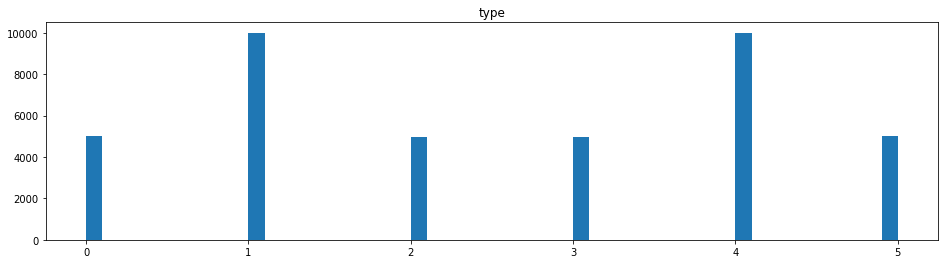

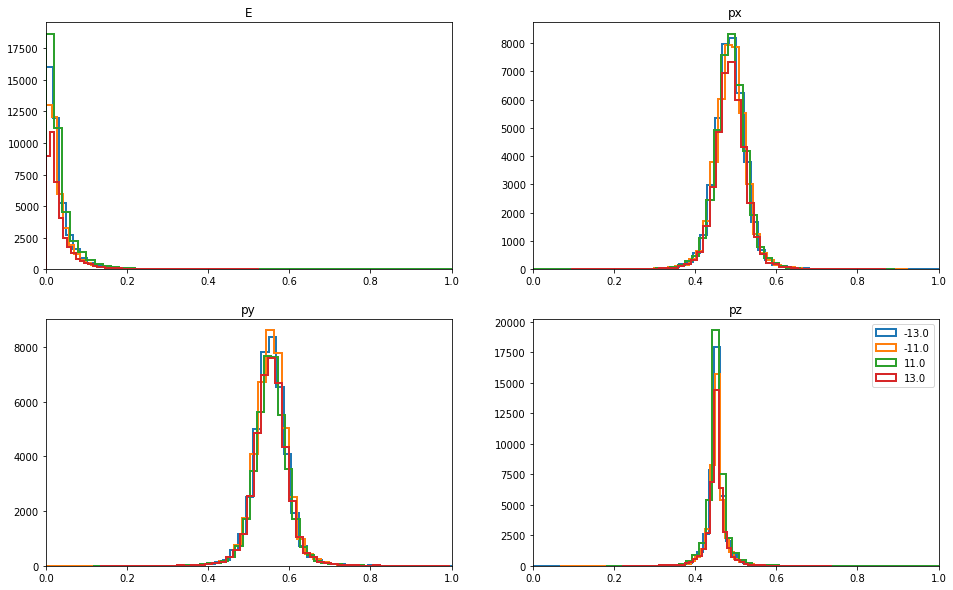

In [103]:
plot_histos(X_codes, X_props, normal_scale=True)

In [655]:
m_real = get_m_values(data_raw)

In [656]:
x = data_raw.values[:,particle_prop_cols]

In [657]:
p = []
for i in range(4):
    p.append(np.power(x[:,i] + x[:,4 + i] + x[:,8 + i] + x[:,12 + i], 2))
p = np.array(p)
m_real = np.sqrt(p[0,:] - p[1,:] - p[2,:] - p[3,:])

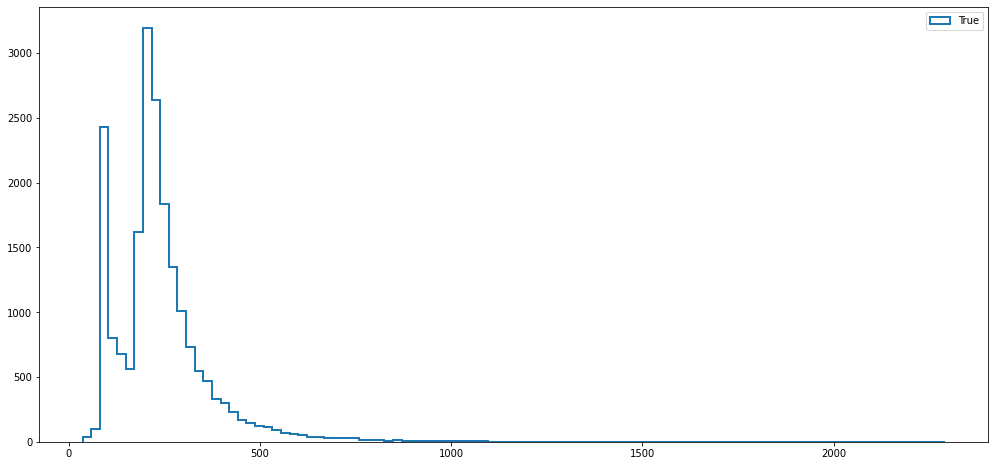

In [658]:
plt.figure(figsize=(17, 8))
plt.hist(m_real, bins=100, histtype='step', linewidth=2, fill=False, label="True")
plt.legend()
plt.show()

In [904]:
scaler_range = scaler.data_range_[[0,1,2,3,0,1,2,3,0,1,2,3,0,1,2,3]].tolist()
scaler_min = scaler.data_min_[[0,1,2,3,0,1,2,3,0,1,2,3,0,1,2,3]].tolist()

In [905]:
@tf.function
def m_calc(y):
    
    e_sum = K.pow(y[:,0] + y[:,4] + y[:,8] + y[:,12], 2)
    x_sum = K.pow(y[:,1] + y[:,5] + y[:,9] + y[:,13], 2)
    y_sum = K.pow(y[:,2] + y[:,6] + y[:,10] + y[:,14], 2)
    z_sum = K.pow(y[:,3] + y[:,7] + y[:,11] + y[:,15], 2)
    
    d = e_sum - x_sum - y_sum - z_sum
    return d
    

@tf.function
def descale(y):
    return y * scaler_range + scaler_min

def m_loss(y_true, y_pred):
    
    m_true = m_calc(descale(y_true))
    m_pred = m_calc(descale(y_pred))

    loss = K.pow(m_pred - m_true, 2)
    #loss = K.sum(loss, axis=1)
    return loss

In [906]:
m_loss(X_props[0:2], X_props[1:3])

<tf.Tensor: shape=(2,), dtype=float64, numpy=array([1.50828731e+09, 7.77402120e+07])>

In [907]:
def create_simple_generator():
    
    inp = Input(shape=(128,))
    
    x = Dense(128, activation='leaky_relu', kernel_initializer='he_normal')(inp)
    x = Dense(256, activation='leaky_relu', kernel_initializer='he_normal')(x)
    x = Dense(512, activation='leaky_relu', kernel_initializer='he_normal')(x)
    
    prop = Dense(activation='linear', units=16)(x)
    
    generator = Model(inputs=inp, outputs=prop)
    generator.compile(loss=m_loss, optimizer='adam')
    
    return generator

generator0 = create_simple_generator()
generator0.summary()

Model: "model_103"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_106 (InputLayer)      [(None, 128)]             0         
                                                                 
 dense_316 (Dense)           (None, 128)               16512     
                                                                 
 dense_317 (Dense)           (None, 256)               33024     
                                                                 
 dense_318 (Dense)           (None, 512)               131584    
                                                                 
 dense_319 (Dense)           (None, 16)                8208      
                                                                 
Total params: 189,328
Trainable params: 189,328
Non-trainable params: 0
_________________________________________________________________


In [908]:
X = np.random.normal(0, 1, [len(X_props), 128])
Y = X_props
X.shape, Y.shape

((40000, 128), (40000, 16))

In [909]:
batch_size = 32
epochs = 1000
losses = []

for _ in tqdm(range(epochs)):
    
    idx1 = np.random.randint(low = 0, high = X.shape[0], size = batch_size)
    idx2 = np.random.randint(low = 0, high = X.shape[0], size = batch_size)
    losses.append(generator0.train_on_batch(X[idx1], Y[idx2]))
    

  0%|          | 0/1000 [00:00<?, ?it/s]

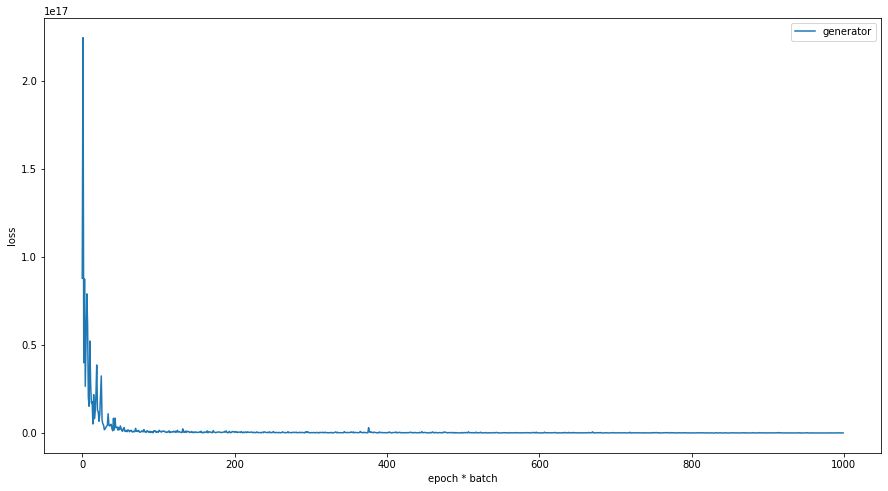

In [910]:
plt.figure(figsize=(15, 8))

plt.plot(losses, label='generator')

plt.ylabel('loss')
plt.xlabel('epoch * batch')
#plt.xscale('log')
plt.legend()
plt.show()

In [911]:
def gaussian_kernel(x1, x2, beta = 1.0):
    r = tf.transpose(x1)
    r = tf.expand_dims(r, 2)
    return tf.reduce_sum(K.exp( -beta * K.square(r - x2)), axis=-1)
  
def MMD(x1, x2, beta = 1.0):
    """
    maximum mean discrepancy (MMD) based on Gaussian kernel
    function for keras models (theano or tensorflow backend)
    
    - Gretton, Arthur, et al. "A kernel method for the two-sample-problem."
    Advances in neural information processing systems. 2007.
    """

#     x1 = m_calc(descale(x1))
#     x2 = m_calc(descale(x2))
    
    #print(x1, x2)
    
#     x1 = tf.expand_dims(x1, axis=0)
#     x2 = tf.expand_dims(x2, axis=0)
    
    #print(x1, x2)
    
    x1x1 = gaussian_kernel(x1, x1, beta)
    x1x2 = gaussian_kernel(x1, x2, beta)
    x2x2 = gaussian_kernel(x2, x2, beta)
    
    #print(x1x1, x1x2)
    
    diff = tf.reduce_mean(x1x1) - 2 * tf.reduce_mean(x1x2) + tf.reduce_mean(x2x2)
    return diff

In [913]:
MMD(X_props[0:2] , X_props[1:3])

<tf.Tensor: shape=(), dtype=float64, numpy=0.0016204159255561734>

In [923]:
def create_simple_generator():
    
    inp = Input(shape=(128,))
    
    x = Dense(128, activation='leaky_relu', kernel_initializer='he_normal')(inp)
    x = Dense(256, activation='leaky_relu', kernel_initializer='he_normal')(x)
    x = Dense(512, activation='leaky_relu', kernel_initializer='he_normal')(x)
    
    prop = Dense(activation='sigmoid', units=16)(x)
    
    generator = Model(inputs=inp, outputs=prop)
    generator = MinDiffModel(generator, MMDLoss())
    generator.compile(loss='mse', optimizer='adam')
    
    
    return generator

generator0 = create_simple_generator()
generator0.summary()

Model: "min_diff_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 model_105 (Functional)      (None, 16)                189328    
                                                                 
Total params: 189,330
Trainable params: 189,328
Non-trainable params: 2
_________________________________________________________________


In [924]:
batch_size = 32
epochs = 1000
losses = []

for _ in tqdm(range(epochs)):
    
    idx1 = np.random.randint(low = 0, high = X.shape[0], size = batch_size)
    idx2 = np.random.randint(low = 0, high = X.shape[0], size = batch_size)
    losses.append(generator0.train_on_batch(X[idx1], Y[idx2]))
    

  0%|          | 0/1000 [00:00<?, ?it/s]

ValueError: in user code:

    File "/home/valdo/.local/share/virtualenvs/tradegan-zjtqzHfP/lib/python3.8/site-packages/keras/engine/training.py", line 878, in train_function  *
        return step_function(self, iterator)
    File "/home/valdo/.local/share/virtualenvs/tradegan-zjtqzHfP/lib/python3.8/site-packages/keras/engine/training.py", line 867, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/home/valdo/.local/share/virtualenvs/tradegan-zjtqzHfP/lib/python3.8/site-packages/keras/engine/training.py", line 860, in run_step  **
        outputs = model.train_step(data)
    File "/home/valdo/.local/share/virtualenvs/tradegan-zjtqzHfP/lib/python3.8/site-packages/keras/engine/training.py", line 808, in train_step
        y_pred = self(x, training=True)
    File "/home/valdo/.local/share/virtualenvs/tradegan-zjtqzHfP/lib/python3.8/site-packages/keras/utils/traceback_utils.py", line 67, in error_handler
        raise e.with_traceback(filtered_tb) from None

    ValueError: Exception encountered when calling layer "min_diff_model" (type MinDiffModel).
    
    in user code:
    
        File "/home/valdo/.local/share/virtualenvs/tradegan-zjtqzHfP/lib/python3.8/site-packages/tensorflow_model_remediation/min_diff/keras/models/min_diff_model.py", line 591, in call  *
            raise ValueError(
    
        ValueError: call `inputs` must contain MinDiffData during training.
    
    
    Call arguments received:
      • inputs=tf.Tensor(shape=(32, 128), dtype=float32)
      • training=True
      • mask=None


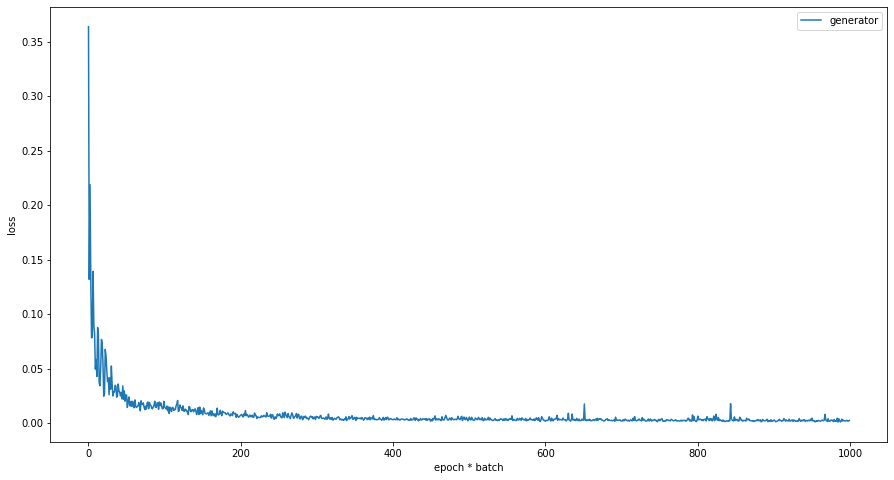

In [734]:
plt.figure(figsize=(15, 8))

plt.plot(losses, label='generator')

plt.ylabel('loss')
plt.xlabel('epoch * batch')
#plt.xscale('log')
plt.legend()
plt.show()

# GAN

In [767]:
noise_len = 512
code_len = X_codes.shape[1]
prop_len = X_props.shape[1]

loss = dict(d=[], g=[], g0=[])

noise_len, code_len, prop_len

(512, 6, 16)

In [768]:
def create_generator():
    
    inp = Input(shape=(noise_len,))
    
    x = Dense(512, activation='leaky_relu', kernel_initializer='he_normal')(inp)
    x = Dense(1024, activation='leaky_relu', kernel_initializer='he_normal')(x)
    x = Dense(2048, activation='leaky_relu', kernel_initializer='he_normal')(x)
    
    prop = Dense(activation='linear', units=prop_len)(x)
    #code = Dense(code_len, activation='softmax')(x)
    
    generator = Model(inputs=inp, outputs=prop)
    generator.compile(loss=MMD, optimizer='adam')
    
    return generator

generator = create_generator()
generator.summary()

Model: "model_99"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_102 (InputLayer)      [(None, 512)]             0         
                                                                 
 dense_304 (Dense)           (None, 512)               262656    
                                                                 
 dense_305 (Dense)           (None, 1024)              525312    
                                                                 
 dense_306 (Dense)           (None, 2048)              2099200   
                                                                 
 dense_307 (Dense)           (None, 16)                32784     
                                                                 
Total params: 2,919,952
Trainable params: 2,919,952
Non-trainable params: 0
_________________________________________________________________


In [769]:
def create_discriminator():

    #inp_code = Input(shape=(code_len,))
    inp_prop = Input(shape=(prop_len,))
    
    #x = Concatenate()((inp_code, inp_prop))
    x = Dense(512, activation='leaky_relu', kernel_initializer='he_normal')(inp_prop)
    #x = Dropout(0.3)(x)
    x = Dense(256, activation='leaky_relu', kernel_initializer='he_normal')(x)
    #x = Dropout(0.3)(x)
    x = Dense(128, activation='leaky_relu', kernel_initializer='he_normal')(x)
    #x = Dropout(0.3)(x)
    
    out = Dense(1, activation='sigmoid')(x)
    
    discriminator = Model(inputs=inp_prop, outputs=out)
    discriminator.compile(loss='binary_crossentropy', optimizer='adam')
    
    return discriminator

discriminator = create_discriminator()
discriminator.summary()

Model: "model_100"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_103 (InputLayer)      [(None, 16)]              0         
                                                                 
 dense_308 (Dense)           (None, 512)               8704      
                                                                 
 dense_309 (Dense)           (None, 256)               131328    
                                                                 
 dense_310 (Dense)           (None, 128)               32896     
                                                                 
 dense_311 (Dense)           (None, 1)                 129       
                                                                 
Total params: 173,057
Trainable params: 173,057
Non-trainable params: 0
_________________________________________________________________


In [770]:
def create_gan(discriminator, generator):
    
    discriminator.trainable = False
    gan_input = Input(shape=(noise_len,))
    prop = generator(gan_input)
    gan_output = discriminator(prop)
    gan = Model(inputs = gan_input, outputs = gan_output)
    gan.compile(loss = 'binary_crossentropy', optimizer = 'adam')
    
    return gan

gan = create_gan(discriminator, generator)
gan.summary()

Model: "model_101"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_104 (InputLayer)      [(None, 512)]             0         
                                                                 
 model_99 (Functional)       (None, 16)                2919952   
                                                                 
 model_100 (Functional)      (None, 1)                 173057    
                                                                 
Total params: 3,093,009
Trainable params: 2,919,952
Non-trainable params: 173,057
_________________________________________________________________


In [898]:
epochs = 10
batch_size = 128
    
with tqdm(total=batch_size) as bbar:
    
    for e in tqdm(range(1, epochs + 1)):
        
        bbar.reset()

        for _ in range(batch_size):

            # Generate random noise as an input to initialize the generator
            noise = np.random.normal(0, 1, [batch_size, noise_len])

            # Generate fake particles from noised input
            fake_batch = generator.predict(noise)

            # Get a random set of real particles
            idx = np.random.randint(low = 0,high = X_codes.shape[0], size = batch_size)
            real_batch = X_props[idx]

            # Construct different batches of real and fake data 
            X = np.concatenate([real_batch, fake_batch])

            # Labels for generated and real data
            Y = np.zeros(2 * batch_size)
            Y[:batch_size] = 0.90

            # Pre train discriminator on fake and real data before starting the gan. 
            discriminator.trainable = True
            
            l = discriminator.train_on_batch(X, Y)
            loss['d'].append(l)

            # Tricking the noised input of the Generator as real data
            X_ = np.random.normal(0, 1, [batch_size, noise_len])
            Y_ = np.ones(batch_size)

            # During the training of gan, the weights of discriminator should be fixed. 
            # We can enforce that by setting the trainable flag
            discriminator.trainable = False

            # Training the GAN by alternating the training of the Discriminator 
            # and training the chained GAN model with Discriminator’s weights freezed.
                
            l = gan.train_on_batch(X_, Y_)
            loss['g'].append(l)
            
            # Train generator on M
            
            noise = np.random.normal(0, 1, [batch_size, noise_len])
            idx = np.random.randint(low = 0, high = X_codes.shape[0], size = batch_size)
            l = generator.train_on_batch(noise, X_props[idx])
            loss['g0'].append(l)
            
            bbar.update(1)
            

  0%|          | 0/128 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

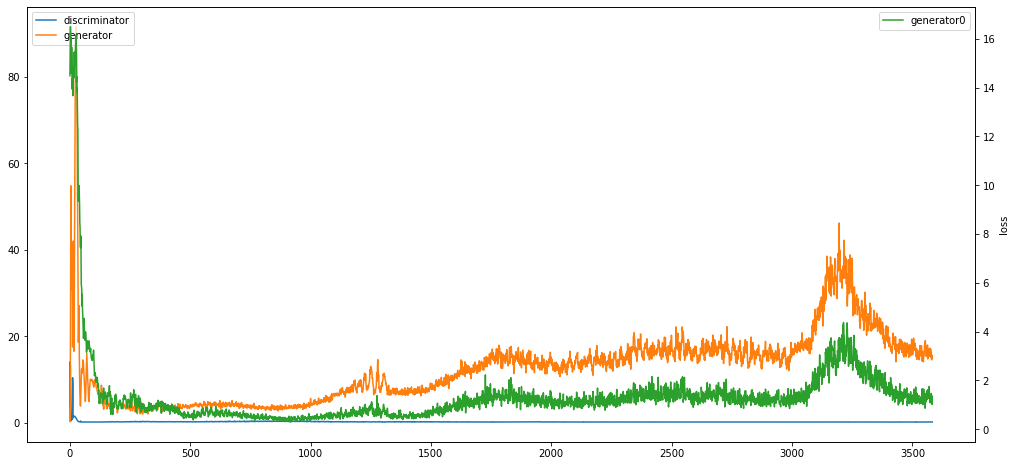

In [878]:
fig, ax1 = plt.subplots(figsize=(17, 8))
ax2 = ax1.twinx()

ax1.plot(loss['d'], color='C0', label='discriminator')
ax1.plot(loss['g'], color='C1', label='generator')
ax2.plot(loss['g0'], color='C2', label='generator0')

plt.ylabel('loss')
plt.xlabel('epoch * batch')
#plt.yscale('log')
ax1.legend(loc=2)
ax2.legend(loc=0)
plt.show()

In [888]:
examples = 100_000
    
noise = np.random.normal(loc = 0, scale = 1, size = [examples, noise_len])
G_props = generator.predict(noise)
G_codes = np.zeros((len(G_props), 6))
G_codes[:,0] = 1.
G_codes.shape, G_props.shape

((100000, 6), (100000, 16))

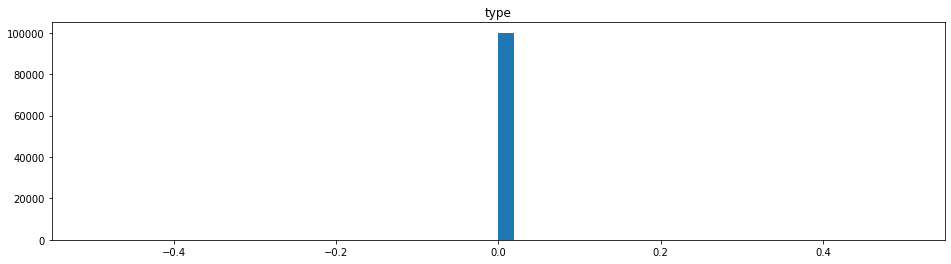

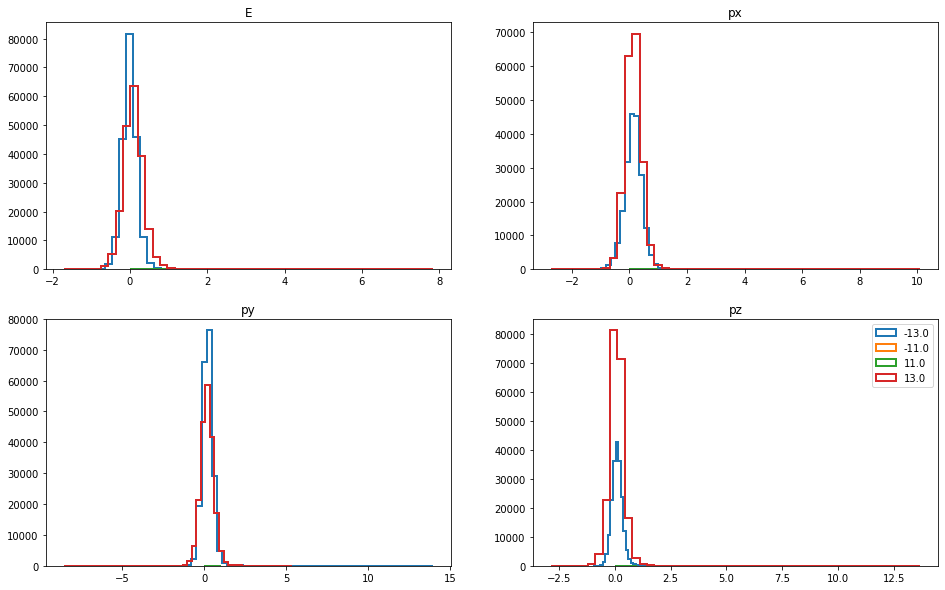

In [889]:
plot_histos(G_codes, G_props, normal_scale=False)

In [890]:
# generator.save('generator_model')

In [891]:
G_stack = np.append(G_props[:,0:4], G_props[:,4:8], axis = 0)
G_stack = np.append(G_stack, G_props[:,8:12], axis = 0)
G_stack = np.append(G_stack, G_props[:,12:16], axis = 0)
G_stack.shape

(400000, 4)

In [892]:
x_ = scaler.inverse_transform(G_stack)
c = x_.shape[0] // 4
x = x_[0:c]
x = np.append(x, x_[c:c*2], axis=1)
x = np.append(x, x_[c*2:c*3], axis=1)
x = np.append(x, x_[c*3:c*4], axis=1)

y = event_types[np.argmax(G_codes, axis=1)]
x.shape, y.shape

((100000, 16), (100000, 4))

In [893]:
data_gen = y[:,0:1]
data_gen = np.append(data_gen, x[:,0:4], axis=1)

data_gen = np.append(data_gen, y[:,1:2], axis=1)
data_gen = np.append(data_gen, x[:,4:8], axis=1)

data_gen = np.append(data_gen, y[:,2:3], axis=1)
data_gen = np.append(data_gen, x[:,8:12], axis=1)

data_gen = np.append(data_gen, y[:,3:4], axis=1)
data_gen = np.append(data_gen, x[:,12:16], axis=1)

data_gen = pd.DataFrame(data_gen, columns=data_raw.columns)

data_gen.shape

(100000, 20)

In [894]:
data_gen

,pdg1,E1,p1x,p1y,p1z,pdg2,E2,p2x,p2y,p2z,pdg3,E3,p3x,p3y,p3z,pdg4,E4,p4x,p4y,p4z
0,-13.0,-435.574280,-483.557129,-554.212830,-3123.055176,13.0,-423.022583,-447.229736,-718.654785,-2878.624268,-13.0,-490.089630,-670.223633,-623.071655,-2691.223389,13.0,238.155991,-581.127563,-691.382690,-2441.468262
1,-13.0,235.813049,-15.394208,-98.495483,-349.867218,13.0,-568.253052,90.911362,-3.427810,-2338.240234,-13.0,-256.325745,-34.449600,-422.655945,265.130066,13.0,413.728577,-558.530579,227.762146,176.314636
2,-13.0,-590.928894,-771.630554,-892.566467,-2624.378662,13.0,-441.337982,-601.704590,-783.860657,-2614.635254,-13.0,138.974777,-622.875549,-636.998169,-2809.385010,13.0,-335.062500,-825.733582,-856.263306,-5378.501953
3,-13.0,-654.534790,-650.082764,-757.979675,-1606.486450,13.0,-1368.547485,-567.440918,-878.877747,-445.289795,-13.0,112.726074,-212.759399,-206.867844,-2372.145264,13.0,-863.036438,-665.143433,-368.907440,-4679.935547
4,-13.0,-1156.942993,-718.884888,-480.118225,-2052.551758,13.0,-144.798950,-786.001648,-176.310730,-3792.045654,-13.0,-639.471558,-607.039551,-725.883301,-2954.878174,13.0,-90.052505,-583.880859,-687.828308,-4513.075684
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99995,-13.0,-251.106018,-395.630035,-371.035675,-2180.732910,13.0,726.243347,-365.324799,-51.881474,-3270.844727,-13.0,-148.399078,-729.875488,-565.137024,-1896.975830,13.0,299.419403,-391.469818,-580.161194,-2247.903809
99996,-13.0,100.076927,-108.344955,-380.349609,-1249.292725,13.0,317.434021,-462.573273,208.901794,-2106.770264,-13.0,355.782593,-651.883545,-494.190643,-1401.119385,13.0,428.645966,-364.761139,-241.022064,-1917.600342
99997,-13.0,-1706.088135,-708.118896,-810.685242,-1115.917969,13.0,-1833.399170,-207.135147,-529.943176,-1756.675293,-13.0,-22.128532,-335.164001,-170.652145,-2189.192871,13.0,-1506.545044,-994.514526,-50.176453,-4282.970215
99998,-13.0,-397.911377,-362.754150,-302.230896,-2815.763916,13.0,655.035706,-318.232849,-402.199158,-1457.242310,-13.0,23.263201,-636.442993,-405.528961,-2624.577148,13.0,442.346405,-300.110321,-861.325989,-3197.433105


In [895]:
m_gen = get_m_values(data_gen)

/home/valdo/.local/share/virtualenvs/tradegan-zjtqzHfP/lib/python3.8/site-packages/pandas/core/arraylike.py:364: RuntimeWarning: invalid value encountered in sqrt
  result = getattr(ufunc, method)(*inputs, **kwargs)


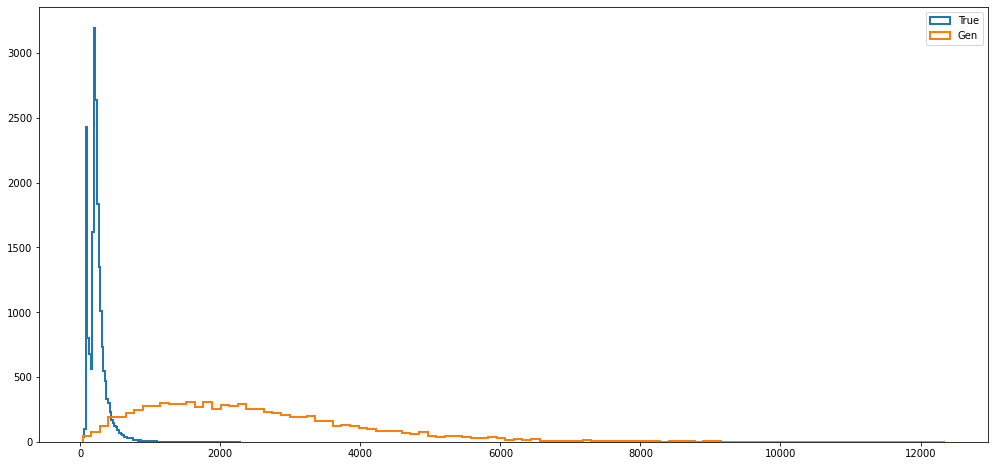

In [896]:
plt.figure(figsize=(17, 8))
plt.hist(m_real, bins=100, histtype='step', linewidth=2, fill=False, label="True")
plt.hist(m_gen, bins=100, histtype='step', linewidth=2, fill=False, label="Gen")
plt.legend()
plt.show()

In [897]:
m_gen

0       NaN
1       NaN
2       NaN
3       NaN
4       NaN
         ..
99995   NaN
99996   NaN
99997   NaN
99998   NaN
99999   NaN
Length: 100000, dtype: float64